In [1]:
from fastai.vision.all import *

# Foundations of computer vision

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/storage/data/mnist_sample/labels.csv'),Path('/storage/data/mnist_sample/valid'),Path('/storage/data/mnist_sample/train')]

In [4]:
(path/'train').ls()

(#2) [Path('/storage/data/mnist_sample/train/7'),Path('/storage/data/mnist_sample/train/3')]

This dataset only contains the subset of '3' and '7' from the original MNIST dataset.

In [5]:
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()
threes

(#6131) [Path('/storage/data/mnist_sample/train/3/10.png'),Path('/storage/data/mnist_sample/train/3/10000.png'),Path('/storage/data/mnist_sample/train/3/10011.png'),Path('/storage/data/mnist_sample/train/3/10031.png'),Path('/storage/data/mnist_sample/train/3/10034.png'),Path('/storage/data/mnist_sample/train/3/10042.png'),Path('/storage/data/mnist_sample/train/3/10052.png'),Path('/storage/data/mnist_sample/train/3/1007.png'),Path('/storage/data/mnist_sample/train/3/10074.png'),Path('/storage/data/mnist_sample/train/3/10091.png')...]

## How are images stored

In [6]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
np.array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [14]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Simple model 1: Pixel similiarity

In [15]:
three_tensors = [tensor(Image.open(path)) for path in threes]
seven_tensors = [tensor(Image.open(path)) for path in sevens]

In [16]:
len(three_tensors), len(seven_tensors)

(6131, 6265)

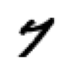

In [35]:
show_image(seven_tensors[1], cmap='gray_r');

Computing the mean value for each pixel:

In [36]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

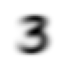

In [37]:
mean3 = stacked_threes.mean(0)
show_image(mean3, cmap='gray_r');

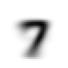

In [38]:
mean7 = stacked_sevens.mean(0)
show_image(mean7, cmap='gray_r');

#### Distance to ideal number

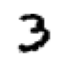

In [42]:
sample_3 = three_tensors[4].float()/255
show_image(sample_3, cmap='gray_r');

In [45]:
diff3 = ((mean3 - sample_3)**2).mean()
diff7 = ((mean7 - sample_3)**2).mean()
diff3, diff7

(tensor(0.0561), tensor(0.0977))

These loss functions are bundled in pytorchs nn.functional module:
- mse_loss
- l1_loss

In [50]:
F.mse_loss(sample_3, mean3), F.mse_loss(sample_3, mean7)

(tensor(0.0561), tensor(0.0977))

#### Validation loss

In [51]:
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

In [52]:
%%time
three_tensors = [tensor(Image.open(path)) for path in valid_threes]
seven_tensors = [tensor(Image.open(path)) for path in valid_sevens]

CPU times: user 660 ms, sys: 108 ms, total: 768 ms
Wall time: 3.87 s


In [53]:
valid_stacked_sevens = torch.stack(seven_tensors).float()/255
valid_stacked_threes = torch.stack(three_tensors).float()/255

In [54]:
valid_stacked_sevens.shape

torch.Size([1028, 28, 28])

In [61]:
def diff_to(stack, mean):
    return (stack - mean).abs().mean(dim=[1,2])

In [67]:
correct_sevens = (diff_to(valid_stacked_sevens, mean3) > diff_to(valid_stacked_sevens, mean7)).sum().item()
correct_threes = (diff_to(valid_stacked_threes, mean3) < diff_to(valid_stacked_threes, mean7)).sum().item()

total_correct = correct_sevens + correct_threes
total = len(valid_threes) + len(valid_sevens)

print('Correct sevens: ', correct_sevens)
print('Correct threes: ', correct_threes)
print('Total: ', total_correct/total)

Correct sevens:  1013
Correct threes:  926
Total:  0.9514229636898921


# Stochastic Gradient Descent (SGD)